### W drugiej wersji wykonam ten sam algorytm zmieniając wymiar przestrzeni ukrytej do 4.

In [1]:
# importuuję potrzebne biblioteki
import os
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt


from utils.loaders import load_mnist, load_model
from models.AE import Autoencoder

Using TensorFlow backend.


In [2]:
# ustalam parametry oraz tworzę strukturę katalogów do zapisania modeli
SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

MODE =  'build' #'load' #

In [3]:
# pobieramy dane oraz tworzę zbiory treningowe oraz testowe
(x_train, y_train), (x_test, y_test) = load_mnist()

In [4]:
# definicja struktury autoenkodera. Definiujemy poniżej parametry poszczególnych warstw
AE = Autoencoder(
    input_dim = (28,28,1)  #wymiar wejścia
    # definicja sekwencyjnego stosu warstw konwolucyjnych 
    , encoder_conv_filters = [32,64,64, 64]  # wymiar filtrów
    , encoder_conv_kernel_size = [3,3,3,3]  # wymiar jądra warstwy splotowej
    , encoder_conv_strides = [1,2,2,1]   # krok przemieszczenia jądra
    , decoder_conv_t_filters = [64,64,32,1]  # wymiar filtrów transponowanych 
    , decoder_conv_t_kernel_size = [3,3,3,3] # wymiar jądra transponowanego 
    , decoder_conv_t_strides = [1,2,2,1] # liczba kroków transponowanych 
    , z_dim = 4
)

if MODE == 'build':
    AE.save(RUN_FOLDER)
else:
    AE.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

W0126 22:08:51.065319 15068 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0126 22:08:51.095466 15068 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [5]:
# przyglądam się strukturze naszego modelu
AE.encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

W porównaniu do modelu z dwuwymiarową przestrzenią ukrytą, spuchła nam o 6k liczba parametrów na ostatnim węźle 

In [7]:
# definiuję hiperparametry, stosuję typowe dla tego typu problemu
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0

In [9]:
# należy pamiętać o skompilowaniu modelu po dowolnej modyfikacji parametrów np. po rozmrożeniu warstw, inicjacji parametrów
AE.compile(LEARNING_RATE)

In [ ]:
# Trenuję model
AE.train(     
    x_train[:1000]
    , batch_size = BATCH_SIZE
    , epochs = 200
    , run_folder = RUN_FOLDER
    , initial_epoch = INITIAL_EPOCH
)

In [ ]:
# ładujemy model jeżeli wystartujemy kolejny raz żeby nie trzeba było go trenować za każdym razem
AE = load_model(Autoencoder, RUN_FOLDER)

W pierwotnym rozwiązaniu w tym miejscu byliśmy już przygotowani do przygotowania grafiki. Teraz niestety przestrzeń ukryta jest czterowymiarowa przez co grafika odpada...

In [13]:
from sklearn.svm import SVC

# tworzę wartswę ukrytą i na niej buduję multiklasowy model SVM 
X_svm = AE.encoder.predict(x_test)
y_svm = y_test

print(X_svm.shape)

(10000, 4)


Aby przedstawić np. biznesowi graficzną reprezentację przestrzeni oraz ewentualnego modelu, dokonam redukcji wymiarowości. Przestrzeń raczej nie jest liniowo rozdzielna więc zastosuję kernelizowaną wersję PCA. Czyli plan jest taki:
1. Dokonuję redukcji wymiarowości -> PCA
2. Dokonuję optymalnego doboru hiperparametrów dla PCA aby zmaksymalizować wariancję modelu -> GridSchearch
3. Na zrzucie powtarzam ćwiczenie dla znanego już nam rozwiązania tj. dwóch wymiarów
4. Mogę już zaprezentować graficznie model SVM oraz hiperparametry, powtarzam ćwiczenie z wybranymi hiperparametrami dla przesrzeni wielowymiarowej

In [18]:
from sklearn.decomposition import KernelPCA
from sklearn.metrics import mean_squared_error

gamma_grid = [0.001, 0.01, 0.03, 0.06, 0.1, 0.2, 0.5]
output = []

for gamma in gamma_grid:
    rbf_pca = KernelPCA(n_components = 2, kernel = "rbf", gamma = gamma, fit_inverse_transform=True)
    X_reduced = rbf_pca.fit_transform(X_svm) 
    X_preimage = rbf_pca.inverse_transform(X_reduced)
    mse = mean_squared_error(X_svm, X_preimage) # dla standardowego PCA można skorzystać z współczynnika wyjaśnionej wariancji
    output.append((gamma, mse))

output

[(0.001, 23.680641),
 (0.01, 37.425426),
 (0.03, 47.67734),
 (0.06, 50.690777),
 (0.1, 52.628284),
 (0.2, 54.590675),
 (0.5, 55.91044)]

Jeszcze analogiczne ćwiczenie dla standardowego PCA

In [20]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components = 2) 
X_reduced_pca = pca.fit_transform(X_svm)
print("Wytłumaczona część wariancji oryginalnej przestrzeni wynosi ", pca.explained_variance_ratio_ )

print("Skumulowana wytłumaczona część wariancji wynosi: ", np.cumsum(pca.explained_variance_ratio_))

# PCA nie posiada inverce transform, trzeba ją zdefiniować samemu
data_reduced = np.dot(X_svm - pca.mean_, pca.components_.T) # transform
data_original = np.dot(data_reduced, pca.components_) # inverse_transform
print(mean_squared_error(X_svm, data_original))


Wytłumaczona część wariancji oryginalnej przestrzeni wynosi  [0.4516588 0.2475074]
Skumulowana wytłumaczona część wariancji wynosi:  [0.4516588 0.6991662]
32.50109


Trochę kiepsko, dwa wymiary tłumaczą zaledwie 70% pierwotnej wariancji. Ale widać, że błąd rekonstrukcji kPCA dla bardzo małego gamma jest nieco niższe więc z niego skorzystam

In [23]:
rbf_pca = KernelPCA(n_components = 2, kernel = "rbf", gamma = 0.001)
X_reduced = rbf_pca.fit_transform(X_svm) 

W tym miejscu możemy ponownie zbudować model SVM

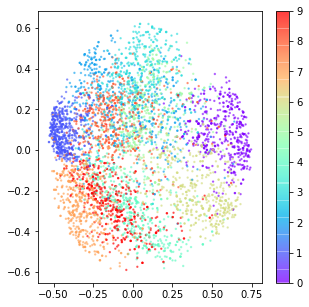

In [25]:
n_to_show = 5000
figsize = 8

example_idx = np.random.choice(range(len(X_reduced)), n_to_show)
example_images = X_reduced[example_idx]
example_labels = y_test[example_idx]

plt.figure(figsize=(5, 5))
plt.scatter(example_images[:, 0] , example_images[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

#plt.savefig("latent_space.png", format='png', dpi=300, facecolor="White")
plt.show()


Przestrzeń wygląda całkiem inaczej niż dla AE o wymiarze przestrzeni ukrytej = 2. Sprawdzam jeszcze jak wygląda dopasowanie modelu SVM i jaką przestrzeń mi wskaże

In [26]:
from sklearn.svm import SVC


# wartości brzegowe przestrzeni ukrytej, zaookrąglę i skorzystam do tworzenia wykresów
print(np.min(example_images[:,0]), np.max(example_images[:,0]))
print(np.min(example_images[:,1]), np.max(example_images[:,1]))


-0.5292728 0.746508
-0.58921146 0.6202409


In [31]:
def plot_comparitions(clf, axis, clf_par, z_points, example_labels):
    x0s = np.linspace(axis[0], axis[1], 100)
    x1s = np.linspace(axis[2], axis[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xn = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(Xn).reshape(x0.shape)
    #wykresy
    fig, axes = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)
    plt.sca(axes[0])
    plt.contourf(x0, x1, y_pred, cmap='rainbow', levels=[0,1,2,3,4,5,6,7,8,9],  alpha=0.5)
    plt.colorbar()
    plt.title("Obszar predykcji SVM, C={0}, gamma={1}".format(clf_par[0],clf_par[1]), fontsize=14)
    plt.sca(axes[1])
    plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
                , alpha=0.5, s=2)
    plt.colorbar()
    plt.title(r"Przestrzeń ukryta autoenkodera", fontsize=14)
    plt.ylabel("")
    plt.savefig("PCA_compare_for_C{0}_gamma{1}.png".format(clf_par[0],clf_par[1]), format='png', dpi=300, facecolor="White")
    plt.show()

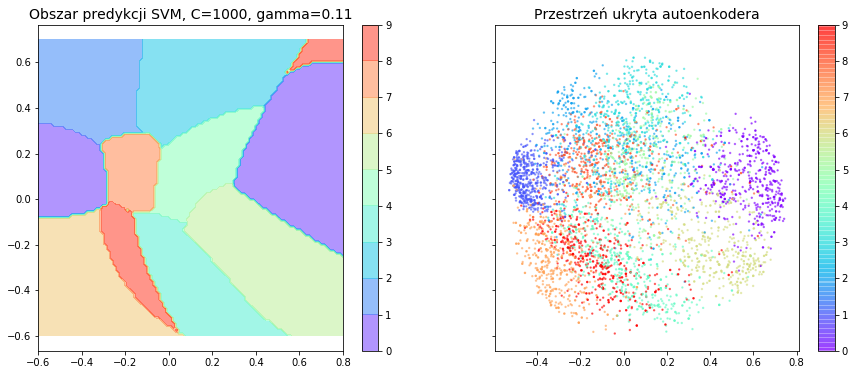

In [32]:
Cp = 1000  #  0.001, 1000
gammap=0.11 # 0.1, 1, 5
svm_model  = SVC(kernel='rbf', gamma = gammap, C=Cp, decision_function_shape='ovo')
svm_model.fit(X_reduced, y_svm)

plot_comparitions(svm_model, [-0.6, 0.8, -0.6, 0.7], [Cp,gammap], example_images, example_labels)

Mamy zatem hiperparametry dla modelu SVM w przestrzeni dwuwymiarowej, możemy je zastosować w przestrzenii 4 i zbudować analogiczny model SVM ale już w czwartym wymiarze. Nim to jednak

In [ ]:
svm_model_PCA = SVC(kernel='rbf', gamma = gammap, C=Cp, decision_function_shape='ovo')